In [ ]:
from notebooks import *

In [ ]:
load = Load()
# with cache_control():  # FIXME Hangs without refresh=True [why?] -- which fortunately doesn't replay the slow .mp3->.wav step
# with cache_control(refresh=True):
with cache_control(refresh=False):
    # recs_all = recs_all if 'recs_all' in locals() else load.recs(
    recs_all = load.recs(
        # limit=150,  # XXX Faster dev (need >100 to get >1 species, else things below break)
        datasets=[
            # 'peterson-field-guide',
            # 'recordings',
            'xc',
        ],
    )
display(
    df_summary(recs_all).T,
    # df_summary(recs_all),
    recs_all[:5],
)

•

min                            25%  \
                 dtype    sizeof  len   count nunique mean      std                                                                       
dataset          object   701760  13760 13760 1       NaN       NaN                                   xc                             xc   
species          category 729280  13760 13760 168     NaN       NaN                                 MOUQ                           CORA   
species_com_name category 886706  13760 13760 168     NaN       NaN                       Mountain Quail                   Common Raven   
species_query    object   729280  13760 13760 168     NaN       NaN                                 ACWO                           CATH   
duration_s       float64  330240  13760 13760 10242   6.323e+01 8.120e+01                          0.216                           20.1   
samples_mb       float64  330240  13760 13760 10242   2.659e+00 3.415e+00                        0.00908                          0.844   
samples_n        int64    385280  13760 13760 10242   1.394e+06 1.790e+06                           4763                         442534   
basename         object   743040  13760 13760 1       NaN       NaN                                audio                          audio   
species_longhand category 983026  13760 13760 168     NaN       NaN                Mountain Quail - MOUQ            Common Raven - CORA   
id               object   1015737 13760 13760 13760   NaN       NaN            xc/data/ACWO/109171/audio      xc/data/CATH/283694/audio   
path             object   1070777 13760 13760 13760   NaN       NaN        xc/data/ACWO/109171/audio.mp3  xc/data/CATH/283694/audio.mp3   
filesize_b       int64    385280  13760 13760 13695   1.286e+06 1.853e+06                          10963                         361742   

                                                                                                    50%                            75%  \
                 dtype    sizeof  len   count nunique mean      std                                                                      
dataset          object   701760  13760 13760 1       NaN       NaN                                  xc                             xc   
species          category 729280  13760 13760 168     NaN       NaN                                RCKI                           WCSP   
species_com_name category 886706  13760 13760 168     NaN       NaN                Ruby-crowned Kinglet          White-crowned Sparrow   
species_query    object   729280  13760 13760 168     NaN       NaN                                HOSP                           RUHU   
duration_s       float64  330240  13760 13760 10242   6.323e+01 8.120e+01                          39.9                           75.8   
samples_mb       float64  330240  13760 13760 10242   2.659e+00 3.415e+00                          1.68                           3.19   
samples_n        int64    385280  13760 13760 10242   1.394e+06 1.790e+06                        880704                        1670976   
basename         object   743040  13760 13760 1       NaN       NaN                               audio                          audio   
species_longhand category 983026  13760 13760 168     NaN       NaN         Ruby-crowned Kinglet - RCKI   White-crowned Sparrow - WCSP   
id               object   1015737 13760 13760 13760   NaN       NaN            xc/data/HOSP/76898/audio      xc/data/RUHU/133576/audio   
path             object   1070777 13760 13760 13760   NaN       NaN        xc/data/HOSP/76898/audio.mp3  xc/data/RUHU/133576/audio.mp3   
filesize_b       int64    385280  13760 13760 13695   1.286e+06 1.853e+06                        760604                        1533623   

                                                                                                    max  
                 dtype    sizeof  len   count nunique mean      std                                      
dataset  

dataset species species_com_name species_query  duration_s  samples_mb  samples_n basename       species_longhand  \
0      xc    MOUQ   Mountain Quail          MOUQ     147.017       6.183    3241728    audio  Mountain Quail - MOUQ   
1      xc    MOUQ   Mountain Quail          MOUQ      70.869       2.981    1562669    audio  Mountain Quail - MOUQ   
2      xc    MOUQ   Mountain Quail          MOUQ      15.596       0.656     343896    audio  Mountain Quail - MOUQ   
3      xc    MOUQ   Mountain Quail          MOUQ      48.171       2.026    1062163    audio  Mountain Quail - MOUQ   
4      xc    MOUQ   Mountain Quail          MOUQ      41.400       1.741     912867    audio  Mountain Quail - MOUQ   

                          id                           path  filesize_b  
0   xc/data/MOUQ/72099/audio   xc/data/MOUQ/72099/audio.mp3     2357229  
1  xc/data/MOUQ/239499/audio  xc/data/MOUQ/239499/audio.mp3     1140133  
2  xc/data/MOUQ/313537/audio  xc/data/MOUQ/313537/audio.mp3      299858  
3  xc/data/MOUQ/329439/audio  xc/data/MOUQ/329439/audio.mp3      776854  
4  xc/data/MOUQ/329454/audio  xc/data/MOUQ/329454/audio.mp3      668764

In [ ]:
(recs_all
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)  # Order species by count
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    # .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs_all: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Subset the data
#   - Runtime: reduce data volume
#   - Class imbalance: clip all classes at the same N (or smaller)
class_count = np.inf   # All species (168)
# class_count = 10     # Faster dev
# class_count = 2     # Faster dev
# class_size = np.inf  # recs[14k]  @ species[168]
# class_size = 200     # recs[12k]  @ species[168]
class_size = 100     # recs[10k]  @ species[168]
# class_size = 50      # recs[7.0k] @ species[168]
# class_size = 20      # recs[3.2k] @ species[168]
# class_size = 10      # recs[1.7k] @ species[168]
# class_size = 5       # recs[.84k] @ species[168]
# class_size = 2       # recs[.34k] @ species[168]
recs = (recs_all
    # Sample class_size per species
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), class_size), random_state=0))
    # Drop classes with <2 instances, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    # Sample class_count of the species
    [lambda df: df.species.isin(df.species.sample(n=min(len(df.species), class_count), random_state=0))]
)
display(
    df_summary(recs_all).T,
    df_summary(recs).T,
)

min                            25%  \
                 dtype    sizeof  len   count nunique mean      std                                                                       
dataset          object   866880  13760 13760 1       NaN       NaN                                   xc                             xc   
species          category 729280  13760 13760 168     NaN       NaN                                 MOUQ                           CORA   
species_com_name category 886706  13760 13760 168     NaN       NaN                       Mountain Quail                   Common Raven   
species_query    object   729380  13760 13760 168     NaN       NaN                                 ACWO                           CATH   
duration_s       float64  330240  13760 13760 10242   6.323e+01 8.120e+01                          0.216                           20.1   
samples_mb       float64  330240  13760 13760 10242   2.659e+00 3.415e+00                        0.00908                          0.844   
samples_n        int64    385280  13760 13760 10242   1.394e+06 1.790e+06                           4763                         442534   
basename         object   743160  13760 13760 1       NaN       NaN                                audio                          audio   
species_longhand category 983026  13760 13760 168     NaN       NaN                Mountain Quail - MOUQ            Common Raven - CORA   
id               object   1016249 13760 13760 13760   NaN       NaN            xc/data/ACWO/109171/audio      xc/data/CATH/283694/audio   
path             object   1071369 13760 13760 13760   NaN       NaN        xc/data/ACWO/109171/audio.mp3  xc/data/CATH/283694/audio.mp3   
filesize_b       int64    385280  13760 13760 13695   1.286e+06 1.853e+06                          10963                         361742   

                                                                                                    50%                            75%  \
                 dtype    sizeof  len   count nunique mean      std                                                                      
dataset          object   866880  13760 13760 1       NaN       NaN                                  xc                             xc   
species          category 729280  13760 13760 168     NaN       NaN                                RCKI                           WCSP   
species_com_name category 886706  13760 13760 168     NaN       NaN                Ruby-crowned Kinglet          White-crowned Sparrow   
species_query    object   729380  13760 13760 168     NaN       NaN                                HOSP                           RUHU   
duration_s       float64  330240  13760 13760 10242   6.323e+01 8.120e+01                          39.9                           75.8   
samples_mb       float64  330240  13760 13760 10242   2.659e+00 3.415e+00                          1.68                           3.19   
samples_n        int64    385280  13760 13760 10242   1.394e+06 1.790e+06                        880704                        1670976   
basename         object   743160  13760 13760 1       NaN       NaN                               audio                          audio   
species_longhand category 983026  13760 13760 168     NaN       NaN         Ruby-crowned Kinglet - RCKI   White-crowned Sparrow - WCSP   
id               object   1016249 13760 13760 13760   NaN       NaN            xc/data/HOSP/76898/audio      xc/data/RUHU/133576/audio   
path             object   1071369 13760 13760 13760   NaN       NaN        xc/data/HOSP/76898/audio.mp3  xc/data/RUHU/133576/audio.mp3   
filesize_b       int64    385280  13760 13760 13695   1.286e+06 1.853e+06                        760604                        1533623   

                                                                                                    max  
                 dtype    sizeof  len   count nunique mean      std                                      
dataset  

min                            25%  \
                 dtype    sizeof len   count nunique mean      std                                                                       
dataset          object   653814 10378 10378 1       NaN       NaN                                   xc                             xc   
species          category 550034 10378 10378 167     NaN       NaN                                 MOUQ                           WAVI   
species_com_name category 674703 10378 10378 167     NaN       NaN                       Mountain Quail                 Warbling Vireo   
species_query    object   550134 10378 10378 167     NaN       NaN                                 ACWO                           CANW   
duration_s       float64  249072 10378 10378 8136    6.257e+01 7.805e+01                          0.497                           19.7   
samples_mb       float64  249072 10378 10378 8136    2.632e+00 3.282e+00                         0.0209                          0.828   
samples_n        int64    290584 10378 10378 8136    1.380e+06 1.721e+06                          10968                         433908   
basename         object   560460 10378 10378 1       NaN       NaN                                audio                          audio   
species_longhand category 747349 10378 10378 167     NaN       NaN                Mountain Quail - MOUQ          Warbling Vireo - WAVI   
id               object   766395 10378 10378 10378   NaN       NaN            xc/data/ACWO/109171/audio      xc/data/CANW/376784/audio   
path             object   807971 10378 10378 10378   NaN       NaN        xc/data/ACWO/109171/audio.mp3  xc/data/CANW/376784/audio.mp3   
filesize_b       int64    290584 10378 10378 10344   1.244e+06 1.704e+06                          13716                         351771   

                                                                                                    50%                           75%  \
                 dtype    sizeof len   count nunique mean      std                                                                      
dataset          object   653814 10378 10378 1       NaN       NaN                                   xc                            xc   
species          category 550034 10378 10378 167     NaN       NaN                                 BGGN                          DEJU   
species_com_name category 674703 10378 10378 167     NaN       NaN                Blue-gray Gnatcatcher               Dark-eyed Junco   
species_query    object   550134 10378 10378 167     NaN       NaN                                 HUVI                          RSHA   
duration_s       float64  249072 10378 10378 8136    6.257e+01 7.805e+01                           39.3                          75.6   
samples_mb       float64  249072 10378 10378 8136    2.632e+00 3.282e+00                           1.65                          3.18   
samples_n        int64    290584 10378 10378 8136    1.380e+06 1.721e+06                         866880                       1666451   
basename         object   560460 10378 10378 1       NaN       NaN                                audio                         audio   
species_longhand category 747349 10378 10378 167     NaN       NaN         Blue-gray Gnatcatcher - BGGN        Dark-eyed Junco - DEJU   
id               object   766395 10378 10378 10378   NaN       NaN            xc/data/HUVI/243816/audio      xc/data/RSHA/55759/audio   
path             object   807971 10378 10378 10378   NaN       NaN        xc/data/HUVI/243816/audio.mp3  xc/data/RSHA/55759/audio.mp3   
filesize_b       int64    290584 10378 10378 10344   1.244e+06 1.704e+06                         741940                       1514838   

                                                                                                   max  
                 dtype    sizeof len   count nunique mean      std                                      
dataset          object   653814 10378

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_bar : Removed 2 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


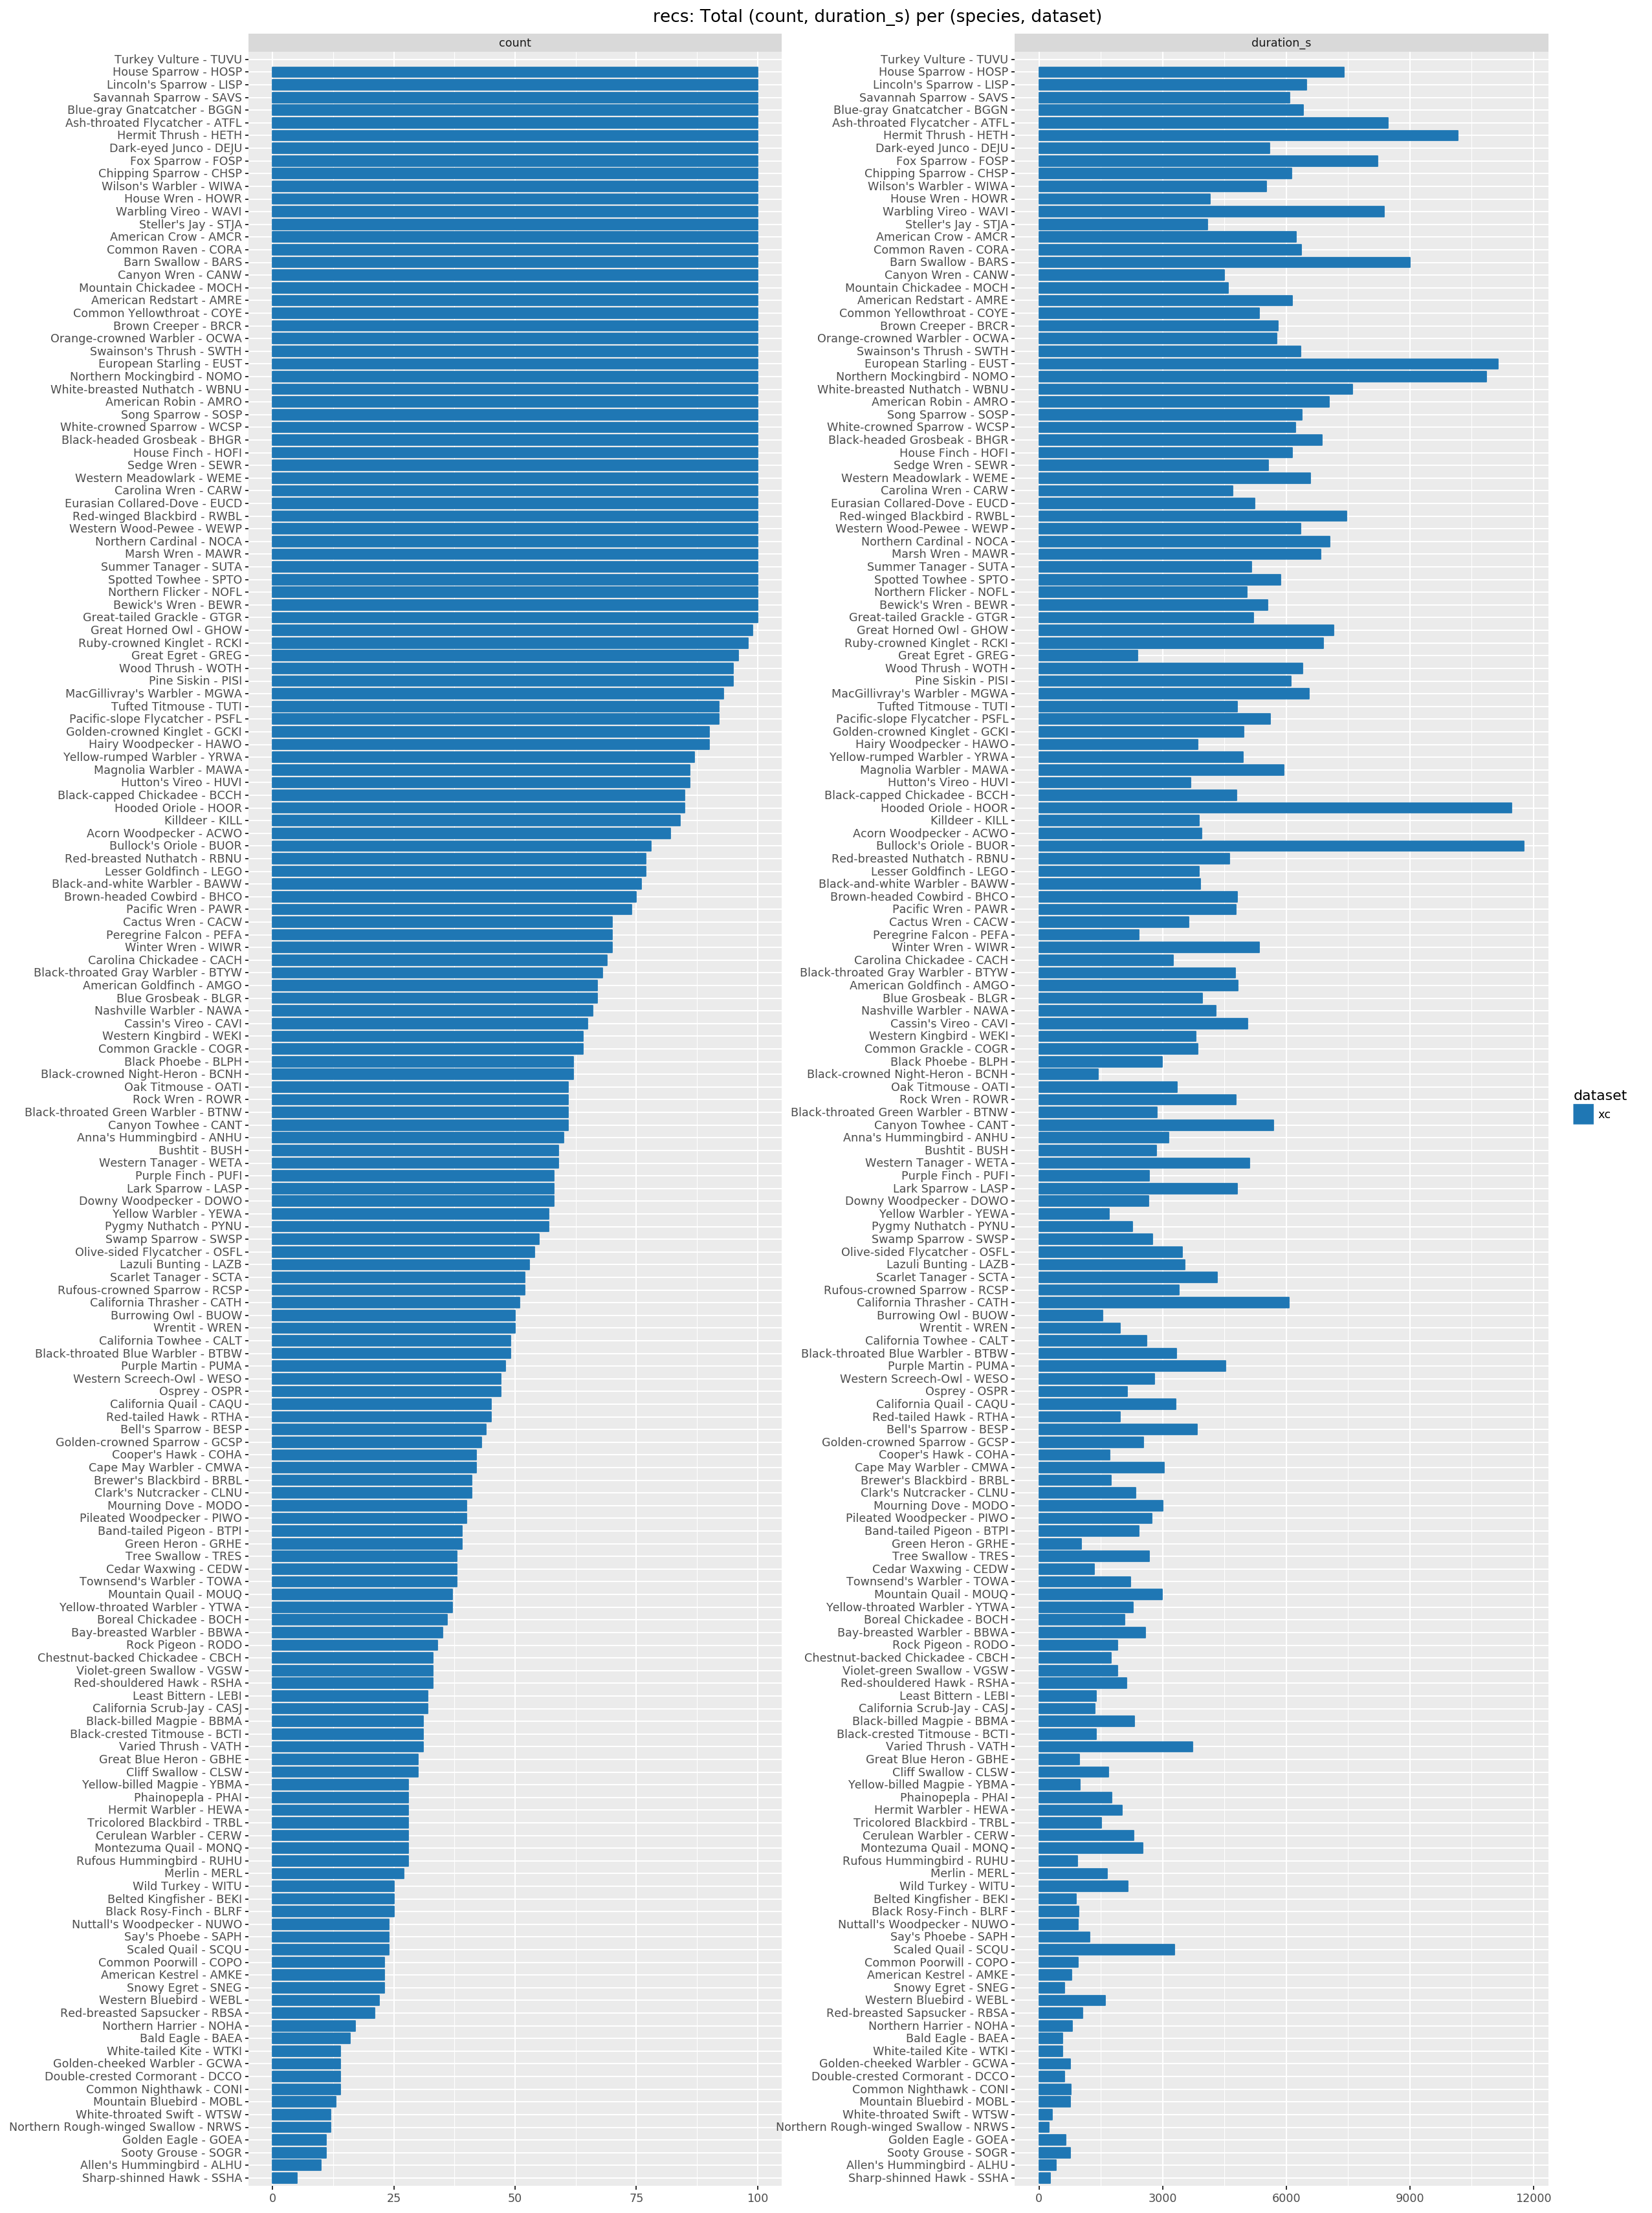

<ggplot: (312721917)>

In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)  # Order species by count
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    # .pipe(df_reverse_cat, 'species')  # Order species by taxo
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

In [ ]:
# Load a saved projection model
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))


[02:54:18.538] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Add .feat
recs = projection.transform(recs)

•

In [ ]:
# XXX Debug downsample_classes
# _search = Search(
#     projection=projection,
#     classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 10',
#     downsample_classes=1.,
# )
# X, y = Search.Xy(recs)
# _search.fit(X, y)

In [ ]:
# GridSearchCV many models / model params
param_grid = dict(
    classifier=[

        # # KNN
        # #   - Bad for large k because we only have ~7-26 instances per class
        # #   - Bad for small k because KNN
        # # 'cls: knn, n_neighbors: 100',
        # 'cls: knn, n_neighbors: 50',
        # 'cls: knn, n_neighbors: 25',
        # # 'cls: knn, n_neighbors: 15',
        # 'cls: knn, n_neighbors: 10',
        # 'cls: knn, n_neighbors: 5',
        # 'cls: knn, n_neighbors: 3',
        # 'cls: knn, n_neighbors: 1',

        # # SVM(RBF)
        # #   - [SBF16] Uses these
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1',
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 10',  # [SBF16]
        # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 100',  # Same as C:10 [why?]
        # # 'cls: svm, random_state: 0, probability: true, kernel: rbf, C: 1000',  # Same as C:10 [why?]

        # # RandomForest(entropy)
        # #   - [SP14] uses entropy
        # # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 10',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 200',  # [SP14]
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 800',
        # 'cls: rf, random_state: 0, criterion: entropy, n_estimators: 1000',

        # # RandomForest(gini)
        # #   - sk uses gini by default
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1',  # Faster dev
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 10',  # [sk default]
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 50',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 100',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 200',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 400',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 600',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 800',
        'cls: rf, random_state: 0, criterion: gini, n_estimators: 1000',
        # WARNING These two are not very mem safe...
        #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 1500',
        # 'cls: rf, random_state: 0, criterion: gini, n_estimators: 2000',

    ],
    # Downsample for learning curves
    downsample_classes=[
        # .1, # Faster dev
        # .1, 1.0,  # Faster dev
        100, 75, 50, 25,  # Biggest first, to fail fast
    ],
    # TODO agg_funs
)

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=3,
        # n_splits=5,
        # n_splits=10,
        n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        test_i='i_test',
        test_y='y_test',
        test_classes='estimator.classes_',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # n_jobs=1,  # For %prun
    # n_jobs=6,  # Doesn't peg all 8 hyperthreads
    n_jobs=8,
    # n_jobs=16,  # Not mem safe, in general (laptop OOMs with 16x rf classifiers)
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 20 folds for each of 4 candidates, totalling 80 fits


[02:54:20.567] INFO   _fit_and_score... split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:20.770] INFO   _fit_and_score... split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:21.009] INFO   _fit_and_score... split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:21.199] INFO   _fit_and_score... split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:21.505] INFO   _fit_and_score... split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:21.679] INFO   _fit_and_score... split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:22.215] INFO   _fit_and_score... split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:54:23.249] INFO   _fit_and_score... split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:29.635] INFO   _fit_and_score[307.416s]: split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:41.016] INFO   _fit_and_score... split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:48.450] INFO   _fit_and_score[326.931s]: split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:48.734] INFO   _fit_and_score[327.047s]: split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:49.265] INFO   _fit_and_score[328.252s]: split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:49.628] INFO   _fit_and_score[328.855s]: split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:53.935] INFO   _fit_and_score[332.731s]: split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:56.268] INFO   _fit_and_score... split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:56.494] INFO   _fit_and_score... split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:56.777] INFO   _fit_and_score... split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:57.203] INFO   _fit_and_score... split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:57.404] INFO   _fit_and_score[336.833s]: split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[02:59:59.496] INFO   _fit_and_score... split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:00:01.755] INFO   _fit_and_score... split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:00:04.636] INFO   _fit_and_score[341.361s]: split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:00:08.492] INFO   _fit_and_score... split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:04:57.180] INFO   _fit_and_score[316.139s]: split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:04:58.345] INFO   _fit_and_score[301.841s]: split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:05.775] INFO   _fit_and_score[308.977s]: split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:08.812] INFO   _fit_and_score... split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:09.956] INFO   _fit_and_score... split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:14.861] INFO   _fit_and_score... split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:17.534] INFO   _fit_and_score[317.955s]: split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:22.924] INFO   _fit_and_score... split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:23.178] INFO   _fit_and_score[325.961s]: split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:23.796] INFO   _fit_and_score[327.511s]: split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:23.932] INFO   _fit_and_score[322.152s]: split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:28.954] INFO   _fit_and_score... split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:29.668] INFO   _fit_and_score... split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:29.912] INFO   _fit_and_score... split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:35.587] INFO   _fit_and_score[327.081s]: split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:05:40.167] INFO   _fit_and_score... split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:10.454] INFO   _fit_and_score[301.627s]: split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:11.750] INFO   _fit_and_score[301.781s]: split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:18.531] INFO   _fit_and_score... split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:19.336] INFO   _fit_and_score... split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:37.782] INFO   _fit_and_score[322.891s]: split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:45.375] INFO   _fit_and_score... split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:50.104] INFO   _fit_and_score[327.166s]: split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=100, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:50.407] INFO   _fit_and_score[320.719s]: split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:50.813] INFO   _fit_and_score[320.877s]: split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:54.335] INFO   _fit_and_score[325.352s]: split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:55.974] INFO   _fit_and_score... split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:56.306] INFO   _fit_and_score... split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:56.633] INFO   _fit_and_score... split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:10:59.406] INFO   _fit_and_score... split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:11:00.854] INFO   _fit_and_score[320.671s]: split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:11:05.385] INFO   _fit_and_score... split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:15:28.905] INFO   _fit_and_score[309.547s]: split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:15:30.542] INFO   _fit_and_score[311.997s]: split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:15:34.868] INFO   _fit_and_score... split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:15:36.529] INFO   _fit_and_score... split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:15:44.742] INFO   _fit_and_score[299.360s]: split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:15:51.434] INFO   _fit_and_score... split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:01.321] INFO   _fit_and_score[301.892s]: split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:07.873] INFO   _fit_and_score... split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:11.566] INFO   _fit_and_score[315.248s]: split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:12.076] INFO   _fit_and_score[306.654s]: split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:16.857] INFO   _fit_and_score... split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:17.350] INFO   _fit_and_score... split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:18.145] INFO   _fit_and_score[321.499s]: split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:22.688] INFO   _fit_and_score... split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:24.155] INFO   _fit_and_score[328.174s]: split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:16:28.526] INFO   _fit_and_score... split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:20:39.665] INFO   _fit_and_score[303.114s]: split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:20:44.706] INFO   _fit_and_score... split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:20:46.747] INFO   _fit_and_score[311.854s]: split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed: 26.5min


[03:20:51.990] INFO   _fit_and_score... split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:20:59.507] INFO   _fit_and_score[308.063s]: split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:05.796] INFO   _fit_and_score... split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:19.921] INFO   _fit_and_score[303.062s]: split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:21.127] INFO   _fit_and_score[303.754s]: split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:26.248] INFO   _fit_and_score... split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:27.057] INFO   _fit_and_score... split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:30.355] INFO   _fit_and_score[322.477s]: split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:35.475] INFO   _fit_and_score... split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:39.430] INFO   _fit_and_score[316.730s]: split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:43.700] INFO   _fit_and_score[315.150s]: split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=75, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:43.902] INFO   _fit_and_score... split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:21:48.256] INFO   _fit_and_score... split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:01.535] INFO   _fit_and_score[316.821s]: split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:01.770] INFO   _fit_and_score[309.761s]: split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:07.121] INFO   _fit_and_score... split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:07.371] INFO   _fit_and_score... split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:14.133] INFO   _fit_and_score[308.314s]: split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:22.047] INFO   _fit_and_score... split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:39.734] INFO   _fit_and_score[312.664s]: split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:43.167] INFO   _fit_and_score[316.894s]: split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:44.505] INFO   _fit_and_score... split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:46.480] INFO   _fit_and_score[302.545s]: split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:47.903] INFO   _fit_and_score... split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:48.067] INFO   _fit_and_score[312.579s]: split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:51.682] INFO   _fit_and_score... split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:26:53.000] INFO   _fit_and_score... split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:27:09.828] INFO   _fit_and_score[321.549s]: split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:27:14.081] INFO   _fit_and_score... split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:20.690] INFO   _fit_and_score[298.628s]: split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:21.498] INFO   _fit_and_score[314.370s]: split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:26.206] INFO   _fit_and_score... split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:26.978] INFO   _fit_and_score... split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:27.689] INFO   _fit_and_score[320.306s]: split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:32.857] INFO   _fit_and_score... split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:43.504] INFO   _fit_and_score[298.995s]: split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:49.715] INFO   _fit_and_score... split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:31:59.231] INFO   _fit_and_score[307.527s]: split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:02.551] INFO   _fit_and_score[314.635s]: split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:03.863] INFO   _fit_and_score... split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:04.438] INFO   _fit_and_score[311.416s]: split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:07.156] INFO   _fit_and_score... split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:09.113] INFO   _fit_and_score... split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:30.656] INFO   _fit_and_score[316.552s]: split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:32:35.080] INFO   _fit_and_score... split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:36:28.582] INFO   _fit_and_score[302.356s]: split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:36:29.592] INFO   _fit_and_score[302.607s]: split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:36:33.657] INFO   _fit_and_score... split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:36:34.784] INFO   _fit_and_score... split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:36:47.734] INFO   _fit_and_score[314.863s]: split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:36:53.410] INFO   _fit_and_score... split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:05.958] INFO   _fit_and_score[316.220s]: split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=50, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:12.025] INFO   _fit_and_score... split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:19.770] INFO   _fit_and_score[312.590s]: split_i[1], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:21.662] INFO   _fit_and_score[312.525s]: split_i[2], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:23.462] INFO   _fit_and_score[319.580s]: split_i[0], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:24.623] INFO   _fit_and_score... split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:26.923] INFO   _fit_and_score... split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:28.729] INFO   _fit_and_score... split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:46.583] INFO   _fit_and_score[311.486s]: split_i[3], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:37:50.896] INFO   _fit_and_score... split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:41:43.016] INFO   _fit_and_score[308.227s]: split_i[5], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:41:43.311] INFO   _fit_and_score[309.629s]: split_i[4], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:41:48.004] INFO   _fit_and_score... split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:41:48.474] INFO   _fit_and_score... split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:41:51.078] INFO   _fit_and_score[297.643s]: split_i[6], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:41:55.400] INFO   _fit_and_score... split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:23.752] INFO   _fit_and_score[295.001s]: split_i[10], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:30.460] INFO   _fit_and_score... split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:35.579] INFO   _fit_and_score[310.942s]: split_i[8], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:37.190] INFO   _fit_and_score[325.141s]: split_i[7], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:40.939] INFO   _fit_and_score... split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:42.533] INFO   _fit_and_score... split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:44.596] INFO   _fit_and_score[317.651s]: split_i[9], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:49.209] INFO   _fit_and_score... split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:51.661] INFO   _fit_and_score[300.742s]: split_i[11], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:42:56.292] INFO   _fit_and_score... split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:46:54.403] INFO   _fit_and_score[305.906s]: split_i[13], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:02.373] INFO   _fit_and_score[314.366s]: split_i[12], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:04.787] INFO   _fit_and_score[309.378s]: split_i[14], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:34.136] INFO   _fit_and_score[293.175s]: split_i[16], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:37.446] INFO   _fit_and_score[294.891s]: split_i[17], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:40.753] INFO   _fit_and_score[310.276s]: split_i[15], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:48.999] INFO   _fit_and_score[299.766s]: split_i[18], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[03:47:52.619] INFO   _fit_and_score[296.323s]: split_i[19], train[8302], test[2076], classes[167], estimator[Search(downsample_classes=25, classifier='cls: rf, random_state: 0, criterion: gini, n_estimators: 1000', random_state=0)]


[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 53.6min finished


In [ ]:
# TODO Debug
# cv.cv_results_

In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, classifier_type, fold, ...
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: {
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_')},
        'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    }))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # classifier_type=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary downsample_classes per classifier)
        classifier_type=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, v) for k, v in d.items() if k not in ['downsample_classes']
        )),
    )
    # .eval
    .assign(test_evals=lambda df: np.vectorize(SearchEvals)(
        i=df.pop('test_i'),
        y=df.pop('test_y'),
        classes=df.pop('test_classes'),
        y_scores=df.pop('test_predict_proba'),
    ))
    # Reorder
    .pipe(df_reorder_cols, first=[
        'model_id', 'params', 'params_dict', 'classifier_type',
    ])
)
param_list = list(cv_models.params.unique())
display(
    df_summary(cv_models).T,
    # cv_models[:5],
    cv_models,
    param_list,
)

min  \
                dtype   sizeof    len count nunique mean std                                                                                                                
model_id        object  12460     80  80    80.0    NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
params          object  11700     80  80    4.0     NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
params_dict     object  19200     80  80    NaN     NaN  NaN                                                                                                          NaN   
classifier_type object  10880     80  80    1.0     NaN  NaN                      classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   2224      80  80    20.0    NaN  NaN                                                                                                            0   
train_score     float64 1920      80  80    3.0     NaN  NaN                                                                                                          -13   
test_score      float64 1920      80  80    6.0     NaN  NaN                                                                                                          -17   
test_evals      object  226132880 80  80    NaN     NaN  NaN                                                                                                          NaN   

                                                                                                                                                                      25%  \
                dtype   sizeof    len count nunique mean std                                                                                                                
model_id        object  12460     80  80    80.0    NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[9]   
params          object  11700     80  80    4.0     NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
params_dict     object  19200     80  80    NaN     NaN  NaN                                                                                                          NaN   
classifier_type object  10880     80  80    1.0     NaN  NaN                      classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   2224      80  80    20.0    NaN  NaN                                                                                                            4   
train_score     float64 1920      80  80    3.0     NaN  NaN                                                                                                          -12   
test_score      float64 1920      80  80    6.0     NaN  NaN                                                                                                          -16   
test_evals      object  226132880 80  80    NaN     NaN  NaN                                                                                                          NaN   

                                                                                                                                                                     50%  \
                dtype   sizeof    len count nunique mean std                                                                                                               
model_id        object  12460     80  80    80.0    NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[9]   
params          object  11700     80  80    4.0     NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
params_dict     

model_id  \
0    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
1    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[1]   
2    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[2]   
3    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[3]   
4    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[4]   
5    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[5]   
6    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[6]   
7    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[7]   
8    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[8]   
9    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[9]   
10  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[10]   
11  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[11]   
12  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[12]   
13  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[13]   
14  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[14]   
15  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[15]   
16  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[16]   
17  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[17]   
18  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[18]   
19  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[19]   
20    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[0]   
21    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[1]   
22    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[2]   
23    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[3]   
24    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[4]   
25    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[5]   
26    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[6]   
27    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[7]   
28    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[8]   
29    classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[9]   
30   classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[10]   
31   classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[11]   
32   classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[12]   
33   classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75], fold[13]   
..                                          

[
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]',
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75]',
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[50]',
  'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]'
]

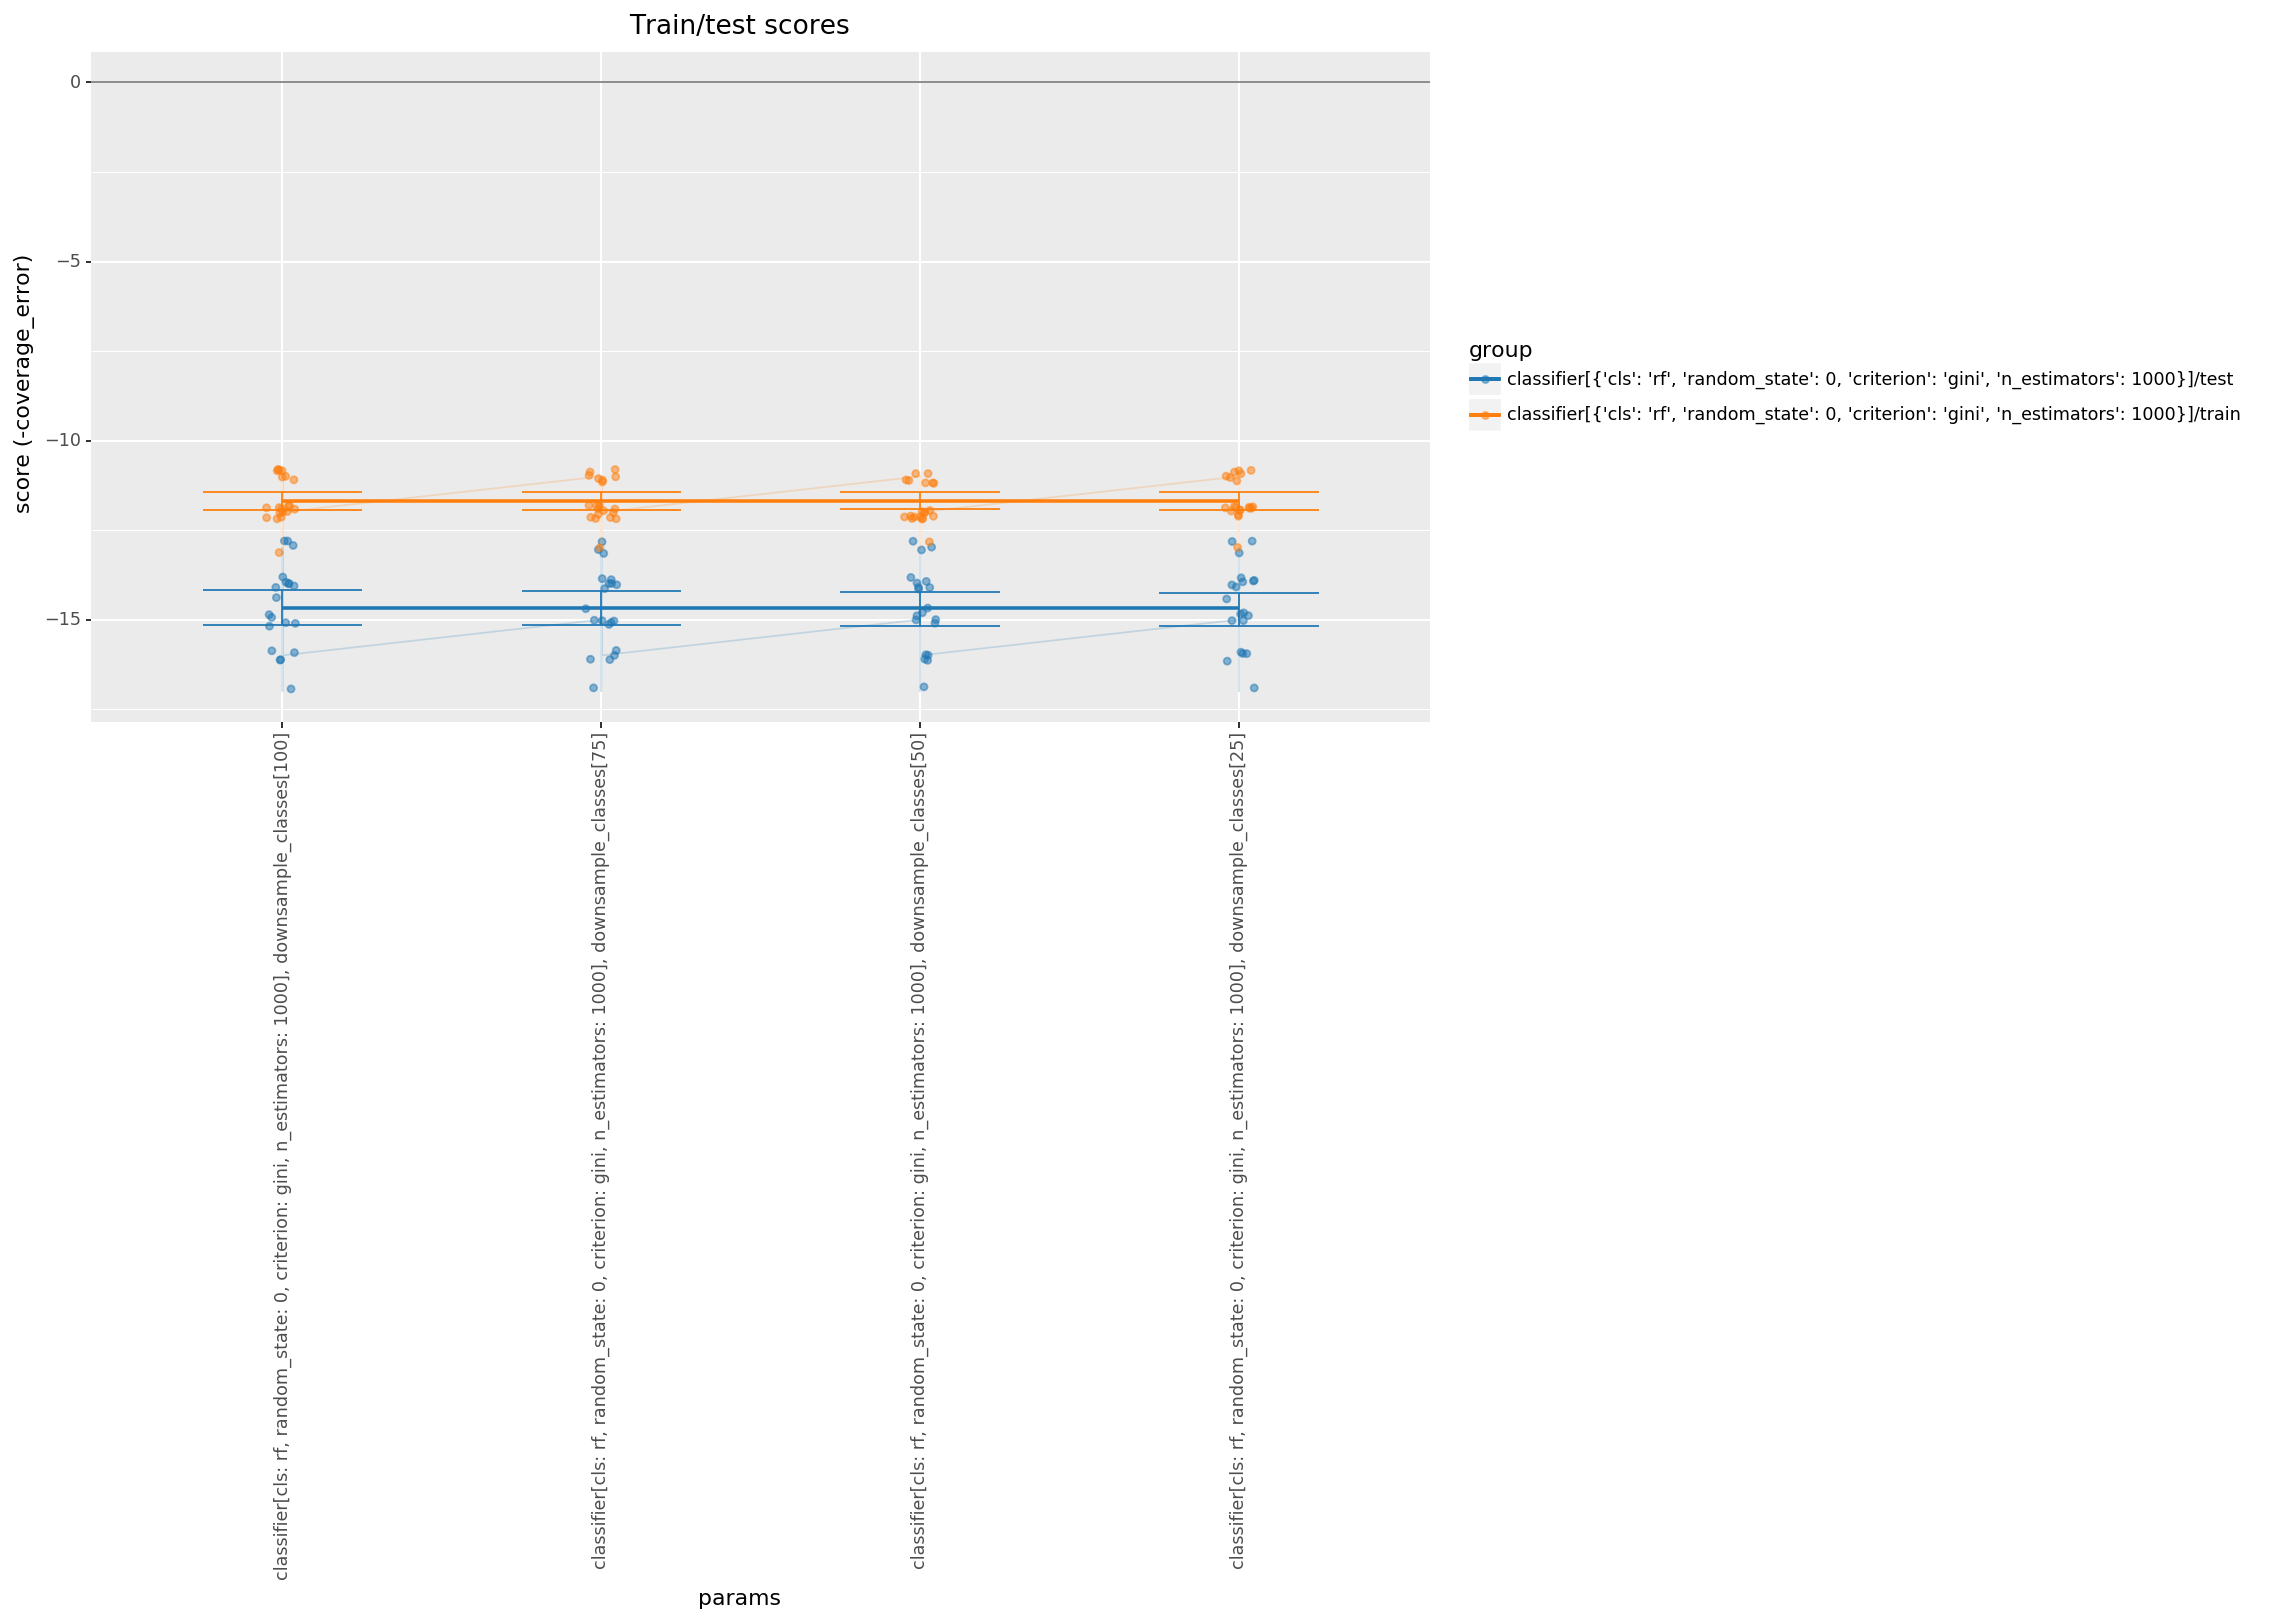

<ggplot: (-9223372036542099775)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['classifier_type', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.apply(axis=1, func=lambda row: row.classifier_type + '/' + row.split),
    )
    .pipe(df_ordered_cat, params=lambda df: param_list)
    .pipe(ggplot, aes(x='params', y='score', color='group'))
    + geom_hline(yintercept=0, color='grey')
    + geom_jitter(alpha=.5, width=.05)
    + geom_line(aes(group='group + str(fold)'), alpha=.2)
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
    + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(axis_text_x=element_text(angle=90, hjust=.5))
    + theme_figsize(width=12, aspect_ratio=1/2)
    # + coord_cartesian(ylim=(-35, 0))
    + ylab('score (-coverage_error)')
    + ggtitle('Train/test scores')
)

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(param_list))
print('  fold[*/%s]' % cv.cv.n_splits)

models:
  params[*/4]
  fold[*/20]


In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            classifier_type=row.classifier_type,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
)
display(
    df_summary(coverage_errors_all_all).T,
    coverage_errors_all_all[:10],
)

  0%|                                                                                                             | 0/80 [00:00<?, ?it/s]

  1%|█▎                                                                                                   | 1/80 [00:00<01:00,  1.31it/s]

  2%|██▌                                                                                                  | 2/80 [00:01<01:00,  1.29it/s]

  4%|███▊                                                                                                 | 3/80 [00:02<01:00,  1.27it/s]

  5%|█████                                                                                                | 4/80 [00:03<00:59,  1.28it/s]

  6%|██████▎                                                                                              | 5/80 [00:03<00:58,  1.27it/s]

  8%|███████▌                                                                                             | 6/80 [00:04<00:58,  1.26it/s]

  9%|████████▊                                                                                            | 7/80 [00:05<00:57,  1.26it/s]

 10%|██████████                                                                                           | 8/80 [00:06<00:57,  1.26it/s]

 11%|███████████▎                                                                                         | 9/80 [00:07<00:56,  1.26it/s]

 12%|████████████▌                                                                                       | 10/80 [00:07<00:55,  1.27it/s]

 14%|█████████████▊                                                                                      | 11/80 [00:08<00:54,  1.27it/s]

 15%|███████████████                                                                                     | 12/80 [00:09<00:53,  1.27it/s]

 16%|████████████████▎                                                                                   | 13/80 [00:10<00:52,  1.27it/s]

 18%|█████████████████▌                                                                                  | 14/80 [00:11<00:51,  1.27it/s]

 19%|██████████████████▊                                                                                 | 15/80 [00:11<00:51,  1.27it/s]

 20%|████████████████████                                                                                | 16/80 [00:12<00:50,  1.27it/s]

 21%|█████████████████████▎                                                                              | 17/80 [00:13<00:49,  1.27it/s]

 22%|██████████████████████▌                                                                             | 18/80 [00:14<00:48,  1.27it/s]

 24%|███████████████████████▊                                                                            | 19/80 [00:14<00:48,  1.27it/s]

 25%|█████████████████████████                                                                           | 20/80 [00:15<00:47,  1.27it/s]

 26%|██████████████████████████▎                                                                         | 21/80 [00:16<00:46,  1.27it/s]

 28%|███████████████████████████▌                                                                        | 22/80 [00:17<00:45,  1.27it/s]

 29%|████████████████████████████▋                                                                       | 23/80 [00:18<00:44,  1.27it/s]

 30%|██████████████████████████████                                                                      | 24/80 [00:18<00:44,  1.27it/s]

 31%|███████████████████████████████▎                                                                    | 25/80 [00:19<00:43,  1.27it/s]

 32%|████████████████████████████████▌                                                                   | 26/80 [00:20<00:42,  1.27it/s]

 34%|█████████████████████████████████▊                                                                  | 27/80 [00:21<00:41,  1.27it/s]

 35%|███████████████████████████████████                                                                 | 28/80 [00:22<00:40,  1.27it/s]

 36%|████████████████████████████████████▎                                                               | 29/80 [00:22<00:40,  1.27it/s]

 38%|█████████████████████████████████████▌                                                              | 30/80 [00:23<00:39,  1.27it/s]

 39%|██████████████████████████████████████▊                                                             | 31/80 [00:24<00:38,  1.27it/s]

 40%|████████████████████████████████████████                                                            | 32/80 [00:25<00:37,  1.27it/s]

 41%|█████████████████████████████████████████▎                                                          | 33/80 [00:25<00:36,  1.27it/s]

 42%|██████████████████████████████████████████▌                                                         | 34/80 [00:26<00:36,  1.27it/s]

 44%|███████████████████████████████████████████▊                                                        | 35/80 [00:27<00:35,  1.27it/s]

 45%|█████████████████████████████████████████████                                                       | 36/80 [00:28<00:34,  1.27it/s]

 46%|██████████████████████████████████████████████▎                                                     | 37/80 [00:29<00:33,  1.27it/s]

 48%|███████████████████████████████████████████████▌                                                    | 38/80 [00:29<00:32,  1.27it/s]

 49%|████████████████████████████████████████████████▊                                                   | 39/80 [00:30<00:32,  1.27it/s]

 50%|██████████████████████████████████████████████████                                                  | 40/80 [00:31<00:31,  1.27it/s]

 51%|███████████████████████████████████████████████████▏                                                | 41/80 [00:32<00:30,  1.28it/s]

 52%|████████████████████████████████████████████████████▌                                               | 42/80 [00:32<00:29,  1.28it/s]

 54%|█████████████████████████████████████████████████████▊                                              | 43/80 [00:33<00:29,  1.27it/s]

 55%|███████████████████████████████████████████████████████                                             | 44/80 [00:34<00:28,  1.27it/s]

 56%|████████████████████████████████████████████████████████▎                                           | 45/80 [00:35<00:27,  1.28it/s]

 57%|█████████████████████████████████████████████████████████▍                                          | 46/80 [00:36<00:26,  1.28it/s]

 59%|██████████████████████████████████████████████████████████▊                                         | 47/80 [00:36<00:25,  1.28it/s]

 60%|████████████████████████████████████████████████████████████                                        | 48/80 [00:37<00:25,  1.28it/s]

 61%|█████████████████████████████████████████████████████████████▎                                      | 49/80 [00:38<00:24,  1.28it/s]

 62%|██████████████████████████████████████████████████████████████▌                                     | 50/80 [00:39<00:23,  1.28it/s]

 64%|███████████████████████████████████████████████████████████████▋                                    | 51/80 [00:39<00:22,  1.28it/s]

 65%|█████████████████████████████████████████████████████████████████                                   | 52/80 [00:40<00:21,  1.28it/s]

 66%|██████████████████████████████████████████████████████████████████▎                                 | 53/80 [00:41<00:21,  1.28it/s]

 68%|███████████████████████████████████████████████████████████████████▌                                | 54/80 [00:42<00:20,  1.28it/s]

 69%|████████████████████████████████████████████████████████████████████▊                               | 55/80 [00:43<00:19,  1.28it/s]

 70%|██████████████████████████████████████████████████████████████████████                              | 56/80 [00:43<00:18,  1.28it/s]

 71%|███████████████████████████████████████████████████████████████████████▎                            | 57/80 [00:44<00:18,  1.28it/s]

 72%|████████████████████████████████████████████████████████████████████████▌                           | 58/80 [00:45<00:17,  1.28it/s]

 74%|█████████████████████████████████████████████████████████████████████████▊                          | 59/80 [00:46<00:16,  1.28it/s]

 75%|███████████████████████████████████████████████████████████████████████████                         | 60/80 [00:47<00:15,  1.27it/s]

 76%|████████████████████████████████████████████████████████████████████████████▎                       | 61/80 [00:47<00:14,  1.28it/s]

 78%|█████████████████████████████████████████████████████████████████████████████▌                      | 62/80 [00:48<00:14,  1.28it/s]

 79%|██████████████████████████████████████████████████████████████████████████████▊                     | 63/80 [00:49<00:13,  1.28it/s]

 80%|████████████████████████████████████████████████████████████████████████████████                    | 64/80 [00:50<00:12,  1.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████▎                  | 65/80 [00:50<00:11,  1.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████▌                 | 66/80 [00:51<00:10,  1.28it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████▊                | 67/80 [00:52<00:10,  1.28it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████               | 68/80 [00:53<00:09,  1.28it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████▎             | 69/80 [00:54<00:08,  1.28it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████▌            | 70/80 [00:54<00:07,  1.28it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████▊           | 71/80 [00:55<00:07,  1.28it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████          | 72/80 [00:56<00:06,  1.28it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████▎        | 73/80 [00:57<00:05,  1.28it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████▌       | 74/80 [00:57<00:04,  1.28it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████▊      | 75/80 [00:58<00:03,  1.28it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████     | 76/80 [00:59<00:03,  1.28it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████▎   | 77/80 [01:00<00:02,  1.28it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████▌  | 78/80 [01:01<00:01,  1.28it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████▊ | 79/80 [01:01<00:00,  1.28it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [01:02<00:00,  1.28it/s]

min  \
                dtype   sizeof   len    count  nunique mean std                                                                                                                
model_id        object  30326208 166080 166080 80      NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
params          object  30816144 166080 166080 4       NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
classifier_type object  26240640 166080 166080 1       NaN  NaN                      classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   4617024  166080 166080 20      NaN  NaN                                                                                                            0   
i               int64   4650144  166080 166080 10241   NaN  NaN                                                                                                            0   
y_true          object  14116800 166080 166080 167     NaN  NaN                                                                                                         ACWO   
coverage_error  float64 3985920  166080 166080 161     NaN  NaN                                                                                                            1   

                                                                                                                                                                         25%  \
                dtype   sizeof   len    count  nunique mean std                                                                                                                
model_id        object  30326208 166080 166080 80      NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[9]   
params          object  30816144 166080 166080 4       NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
classifier_type object  26240640 166080 166080 1       NaN  NaN                      classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   4617024  166080 166080 20      NaN  NaN                                                                                                            4   
i               int64   4650144  166080 166080 10241   NaN  NaN                                                                                                         2599   
y_true          object  14116800 166080 166080 167     NaN  NaN                                                                                                         CANW   
coverage_error  float64 3985920  166080 166080 161     NaN  NaN                                                                                                            3   

                                                                                                                                                                        50%  \
                dtype   sizeof   len    count  nunique mean std                                                                                                               
model_id        object  30326208 166080 166080 80      NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[9]   
params          object  30816144 166080 166080 4       NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
classifier_type object  26240640 166080 166080 1       NaN  NaN                     classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   4617024  166080 166080 20      NaN  NaN                                                             

model_id  \
0  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
1  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
2  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
3  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
4  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
5  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
6  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
7  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
8  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   
9  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100], fold[0]   

                                                                                               params  \
0  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
1  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
2  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
3  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
4  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
5  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
6  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
7  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
8  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   
9  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]   

                                                                           classifier_type  fold      i y_true  coverage_error  
0  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   3336   CACH             4.0  
1  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   8242   LISP            36.0  
2  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   2000   WEWP             3.0  
3  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   2404   HUVI            71.0  
4  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   8057   SAVS             1.0  
5  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   4343   CANW            68.0  
6  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   6713   AMRE            20.0  
7  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   8175   SOSP             6.0  
8  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0  10247   AMGO            27.0  
9  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   6720   AMRE             3.0

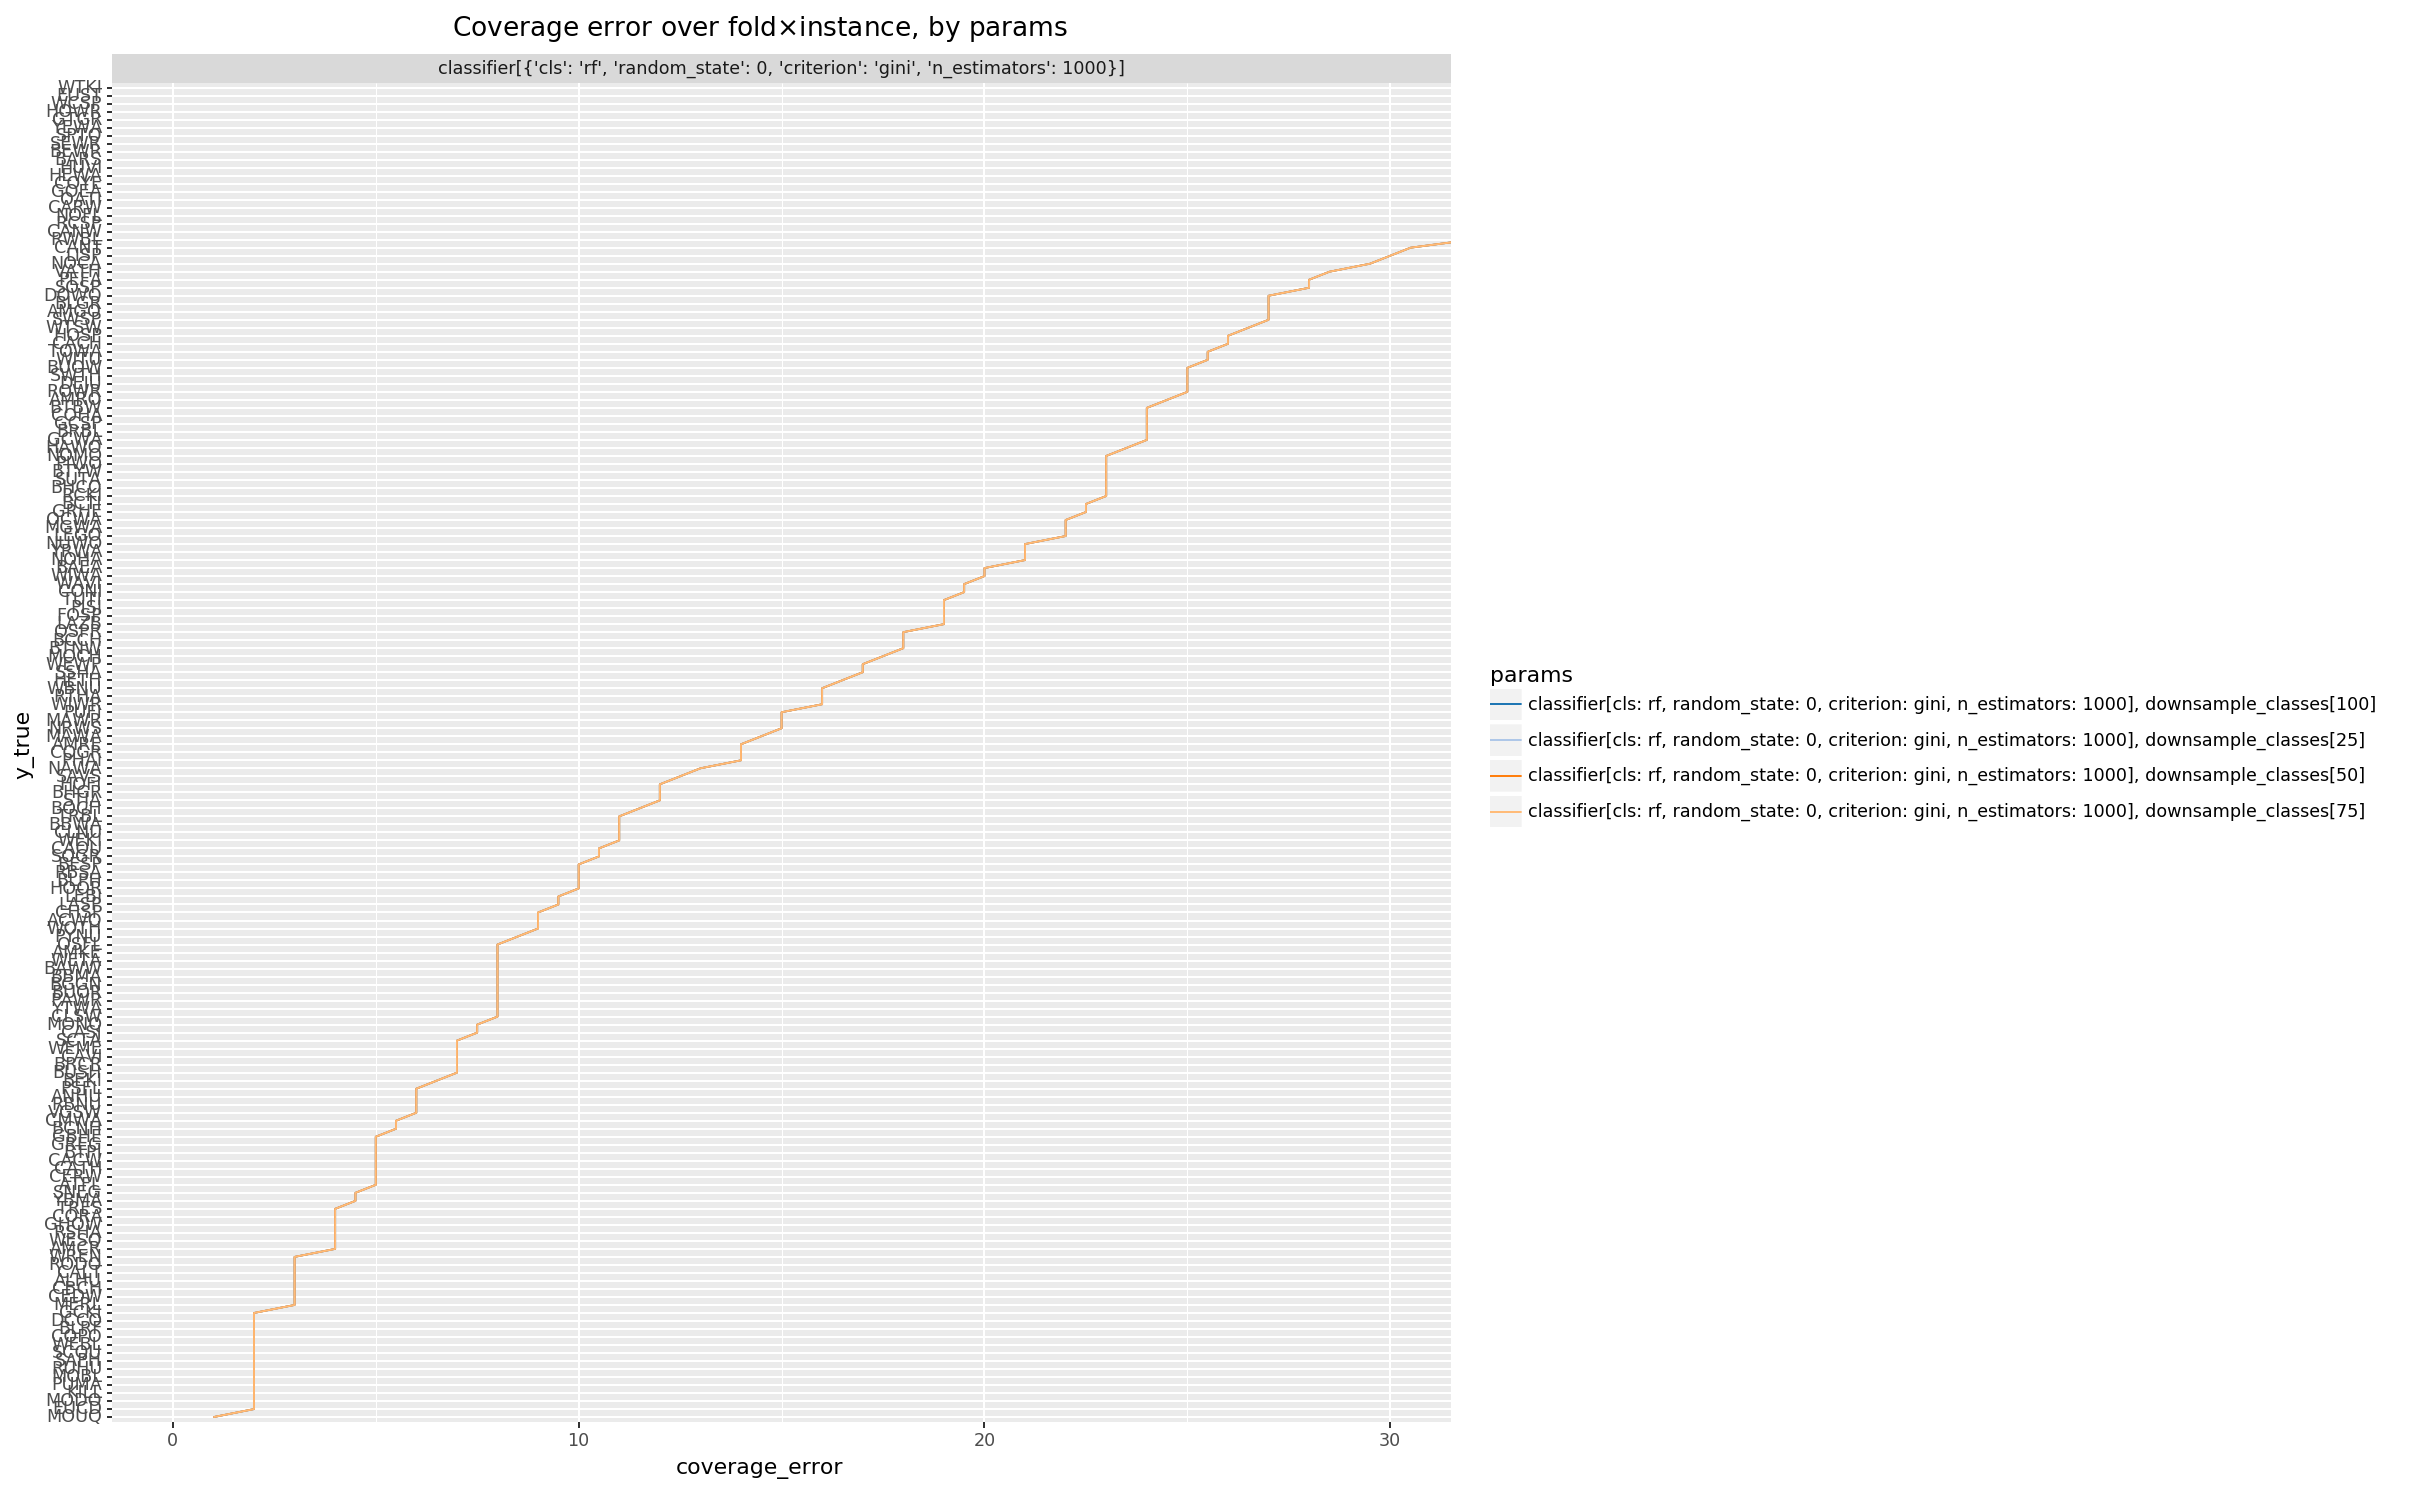

<ggplot: (-9223372036542293465)>

In [ ]:
# Facet by classifier_type, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # Sort species by median(coverage_error) (across all models)
    .pipe(df_ordered_cat, y_true=lambda df: (
        df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
    ))
    .pipe(ggplot, aes(x='y_true', y='coverage_error', color='params'))
    + facet_wrap('classifier_type')
    + geom_line(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(ylim=(0, min(30, len(np.unique(y)))))
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme_figsize('square')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

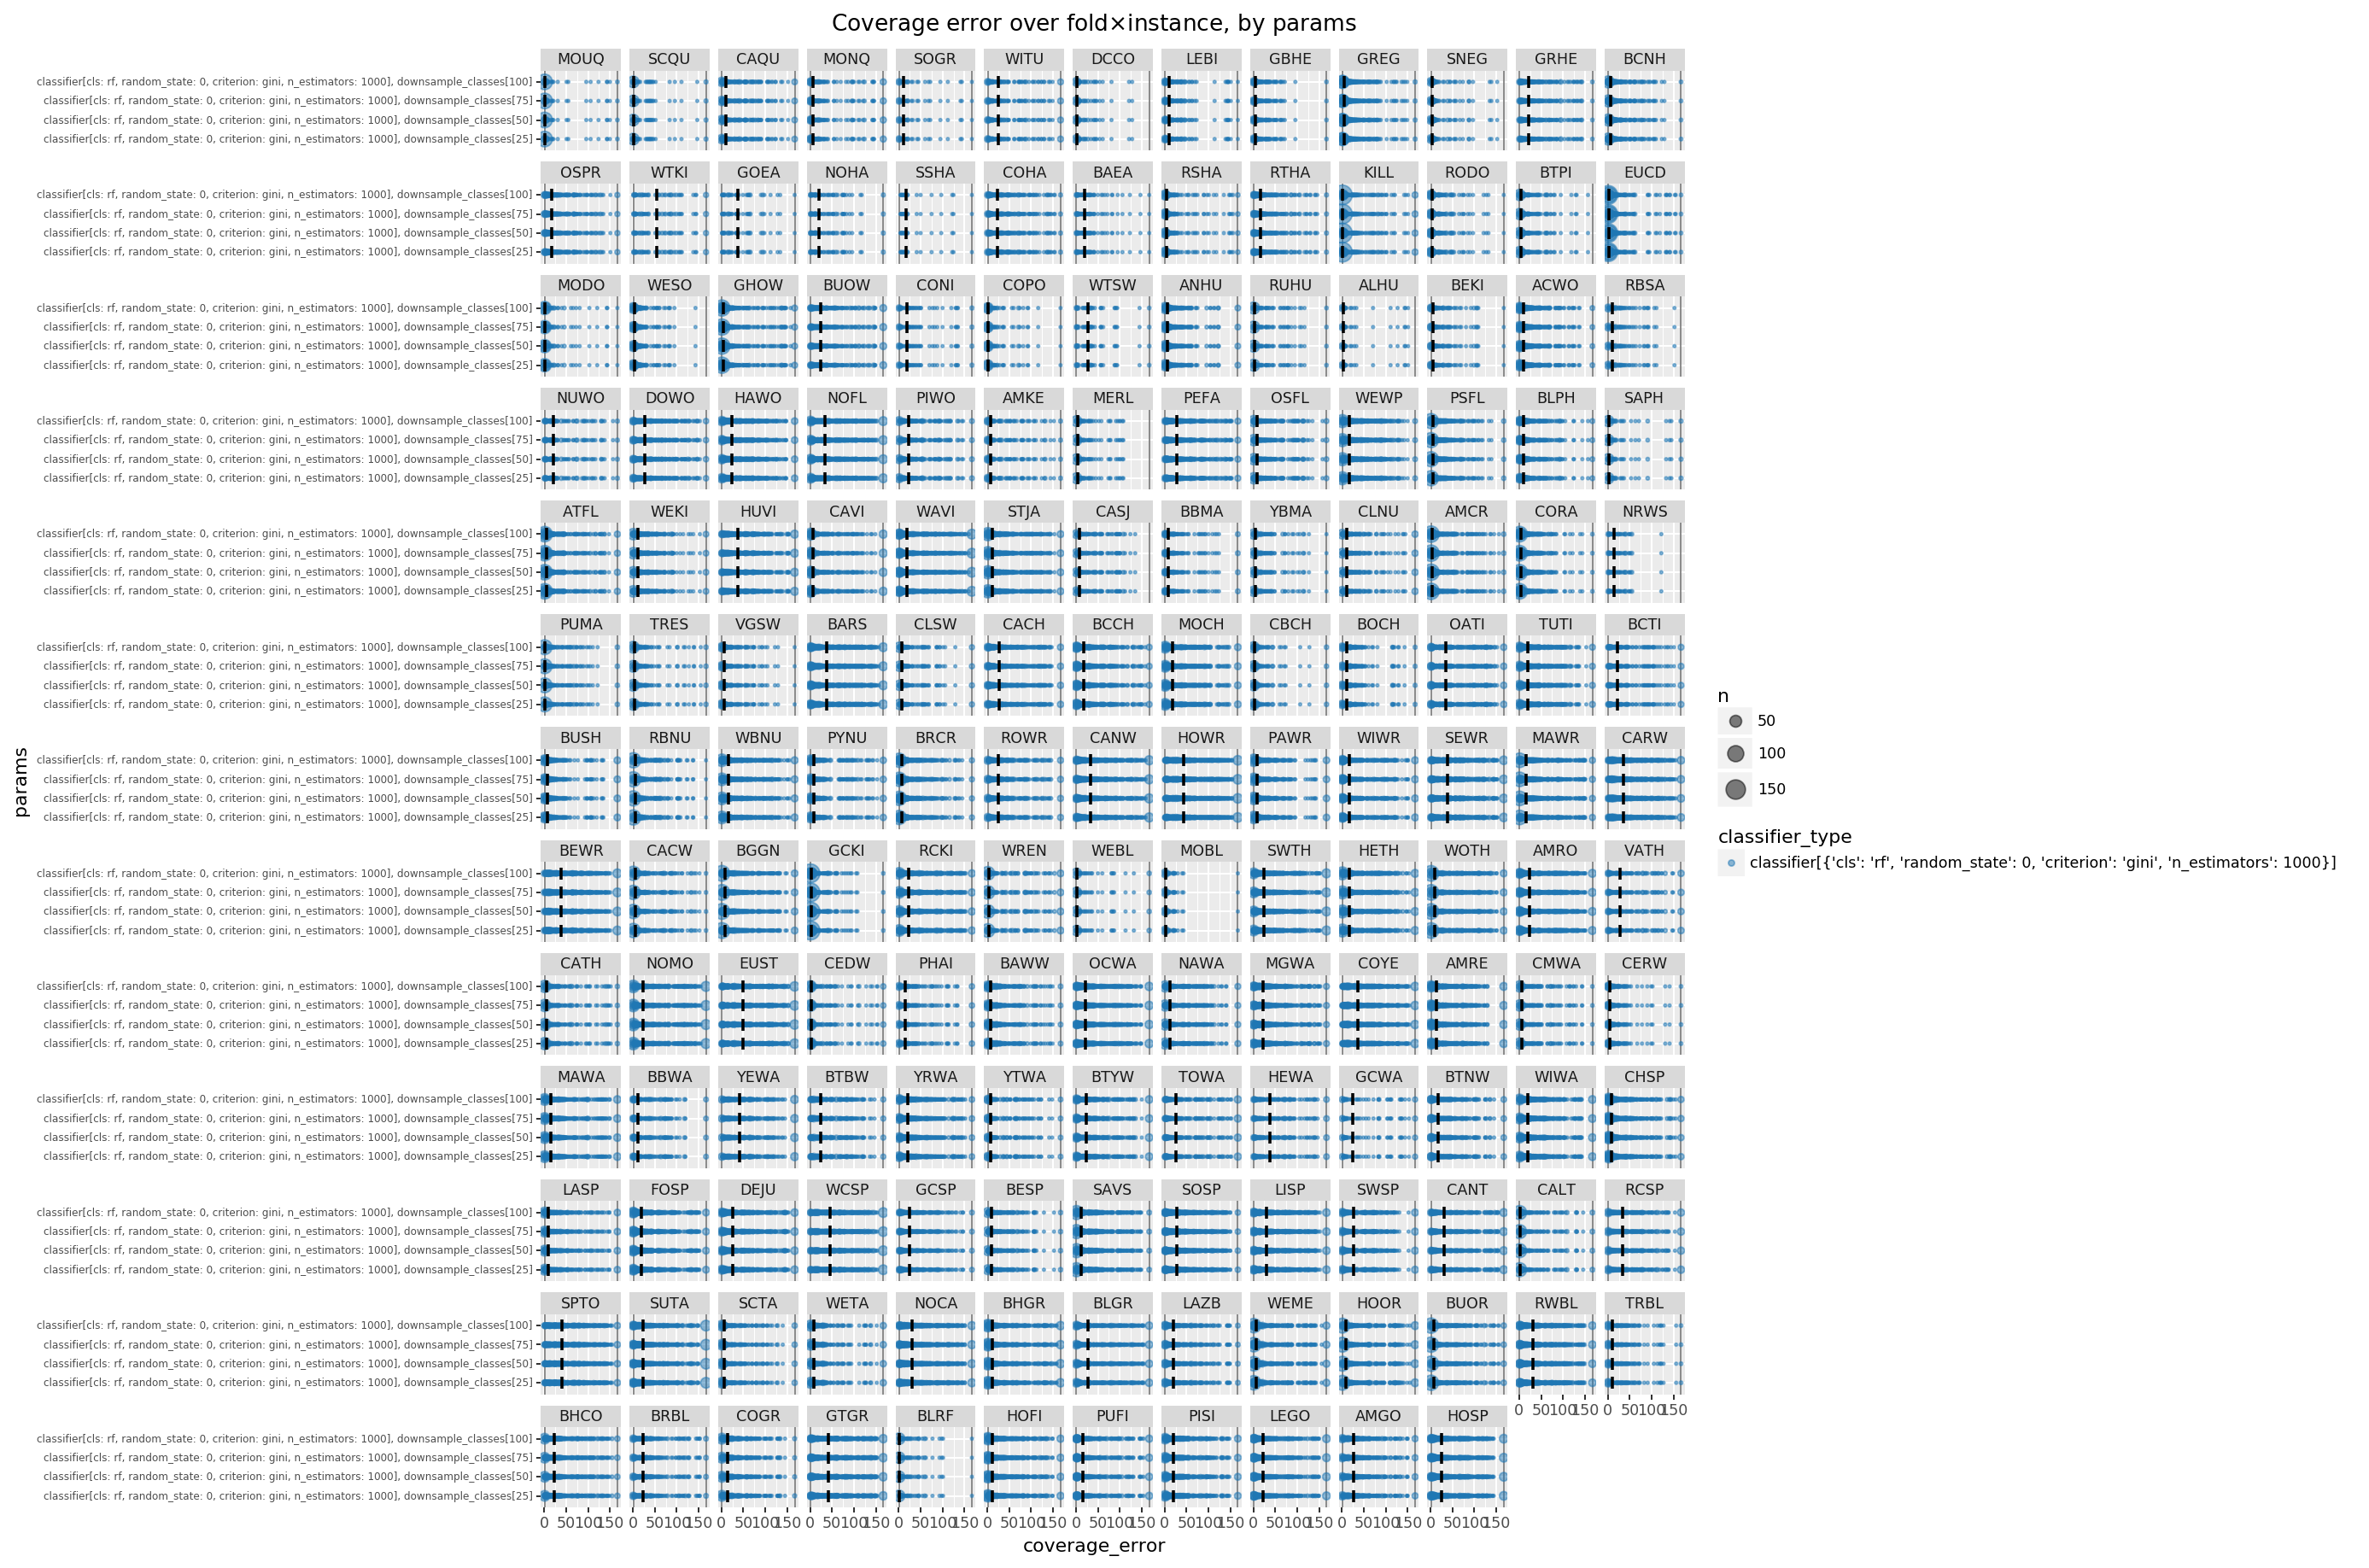

<ggplot: (-9223372036539125872)>

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_ordered_cat, params=lambda df: reversed(param_list))
    .pipe(ggplot, aes(x='params', y='coverage_error', color='classifier_type'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance, by params')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = -1
params = param_list[params_i]
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), params))
print('  fold[*/%s]' % cv.cv.n_splits)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75]'
  2: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[50]'
  3: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]'

models:
  params[-1/4]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]'
  fold[*/20]


In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

min  \
                dtype   sizeof  len   count nunique mean std                                                                                                               
model_id        object  7344888 41520 41520 20      NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
params          object  7689504 41520 41520 1       NaN  NaN           classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
classifier_type object  7108224 41520 41520 1       NaN  NaN                     classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   1154256 41520 41520 20      NaN  NaN                                                                                                           0   
i               int64   1162536 41520 41520 10241   NaN  NaN                                                                                                           0   
y_true          object  3529220 41520 41520 167     NaN  NaN                                                                                                        ACWO   
coverage_error  float64 996480  41520 41520 161     NaN  NaN                                                                                                           1   

                                                                                                                                                                      25%  \
                dtype   sizeof  len   count nunique mean std                                                                                                                
model_id        object  7344888 41520 41520 20      NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[13]   
params          object  7689504 41520 41520 1       NaN  NaN            classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
classifier_type object  7108224 41520 41520 1       NaN  NaN                      classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   1154256 41520 41520 20      NaN  NaN                                                                                                            4   
i               int64   1162536 41520 41520 10241   NaN  NaN                                                                                                         2599   
y_true          object  3529220 41520 41520 167     NaN  NaN                                                                                                         CANW   
coverage_error  float64 996480  41520 41520 161     NaN  NaN                                                                                                            3   

                                                                                                                                                                      50%  \
                dtype   sizeof  len   count nunique mean std                                                                                                                
model_id        object  7344888 41520 41520 20      NaN  NaN  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[18]   
params          object  7689504 41520 41520 1       NaN  NaN            classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
classifier_type object  7108224 41520 41520 1       NaN  NaN                      classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]   
fold            int64   1154256 41520 41520 20      NaN  NaN                                                                                                            9   
i               int6

model_id  \
124560  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124561  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124562  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124563  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124564  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124565  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124566  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124567  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124568  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   
124569  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]   

                                                                                                   params  \
124560  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124561  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124562  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124563  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124564  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124565  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124566  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124567  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124568  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   
124569  classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]   

                                                                                classifier_type  fold      i y_true  coverage_error  
124560  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   3336   CACH             4.0  
124561  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   8242   LISP            36.0  
124562  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   2000   WEWP             3.0  
124563  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   2404   HUVI            71.0  
124564  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   8057   SAVS             1.0  
124565  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   4343   CANW            68.0  
124566  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   6713   AMRE            20.0  
124567  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   8175   SOSP             6.0  
124568  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0  10247   AMGO            27.0  
124569  classifier[{'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}]     0   6720   AMRE             3.0

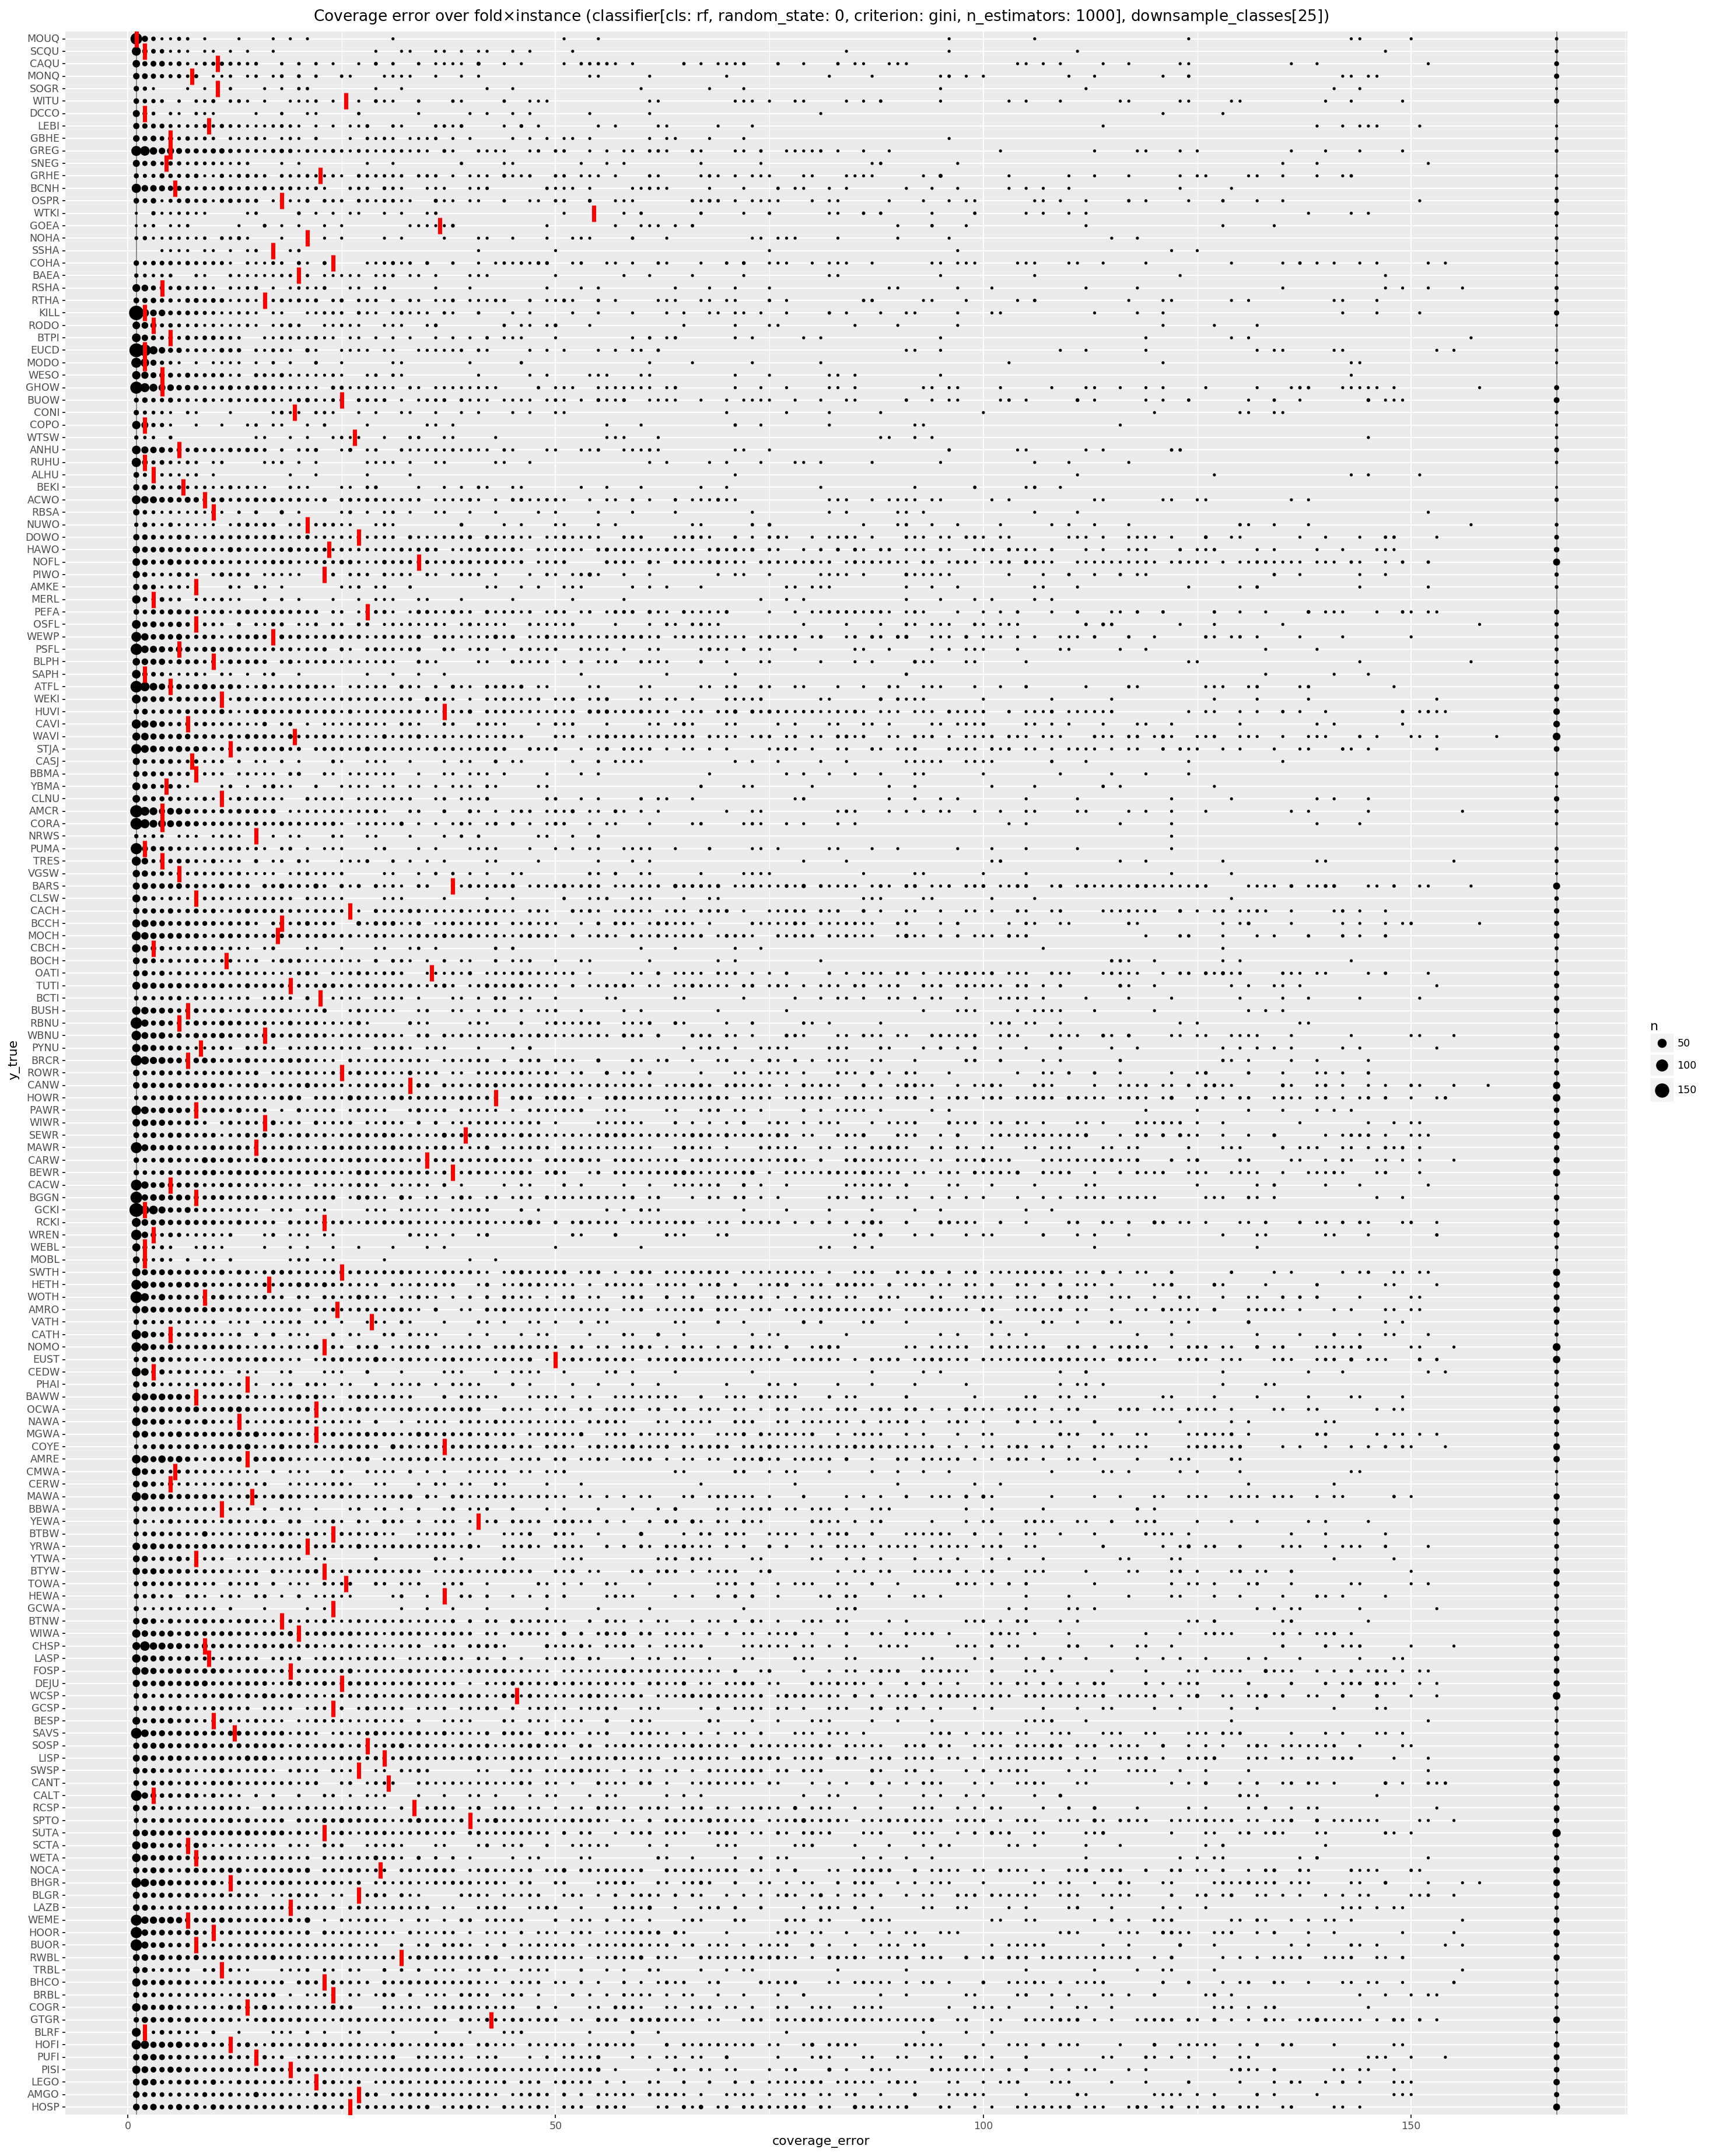

<ggplot: (-9223372036518679864)>

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold$\times$instance ({params})')
)

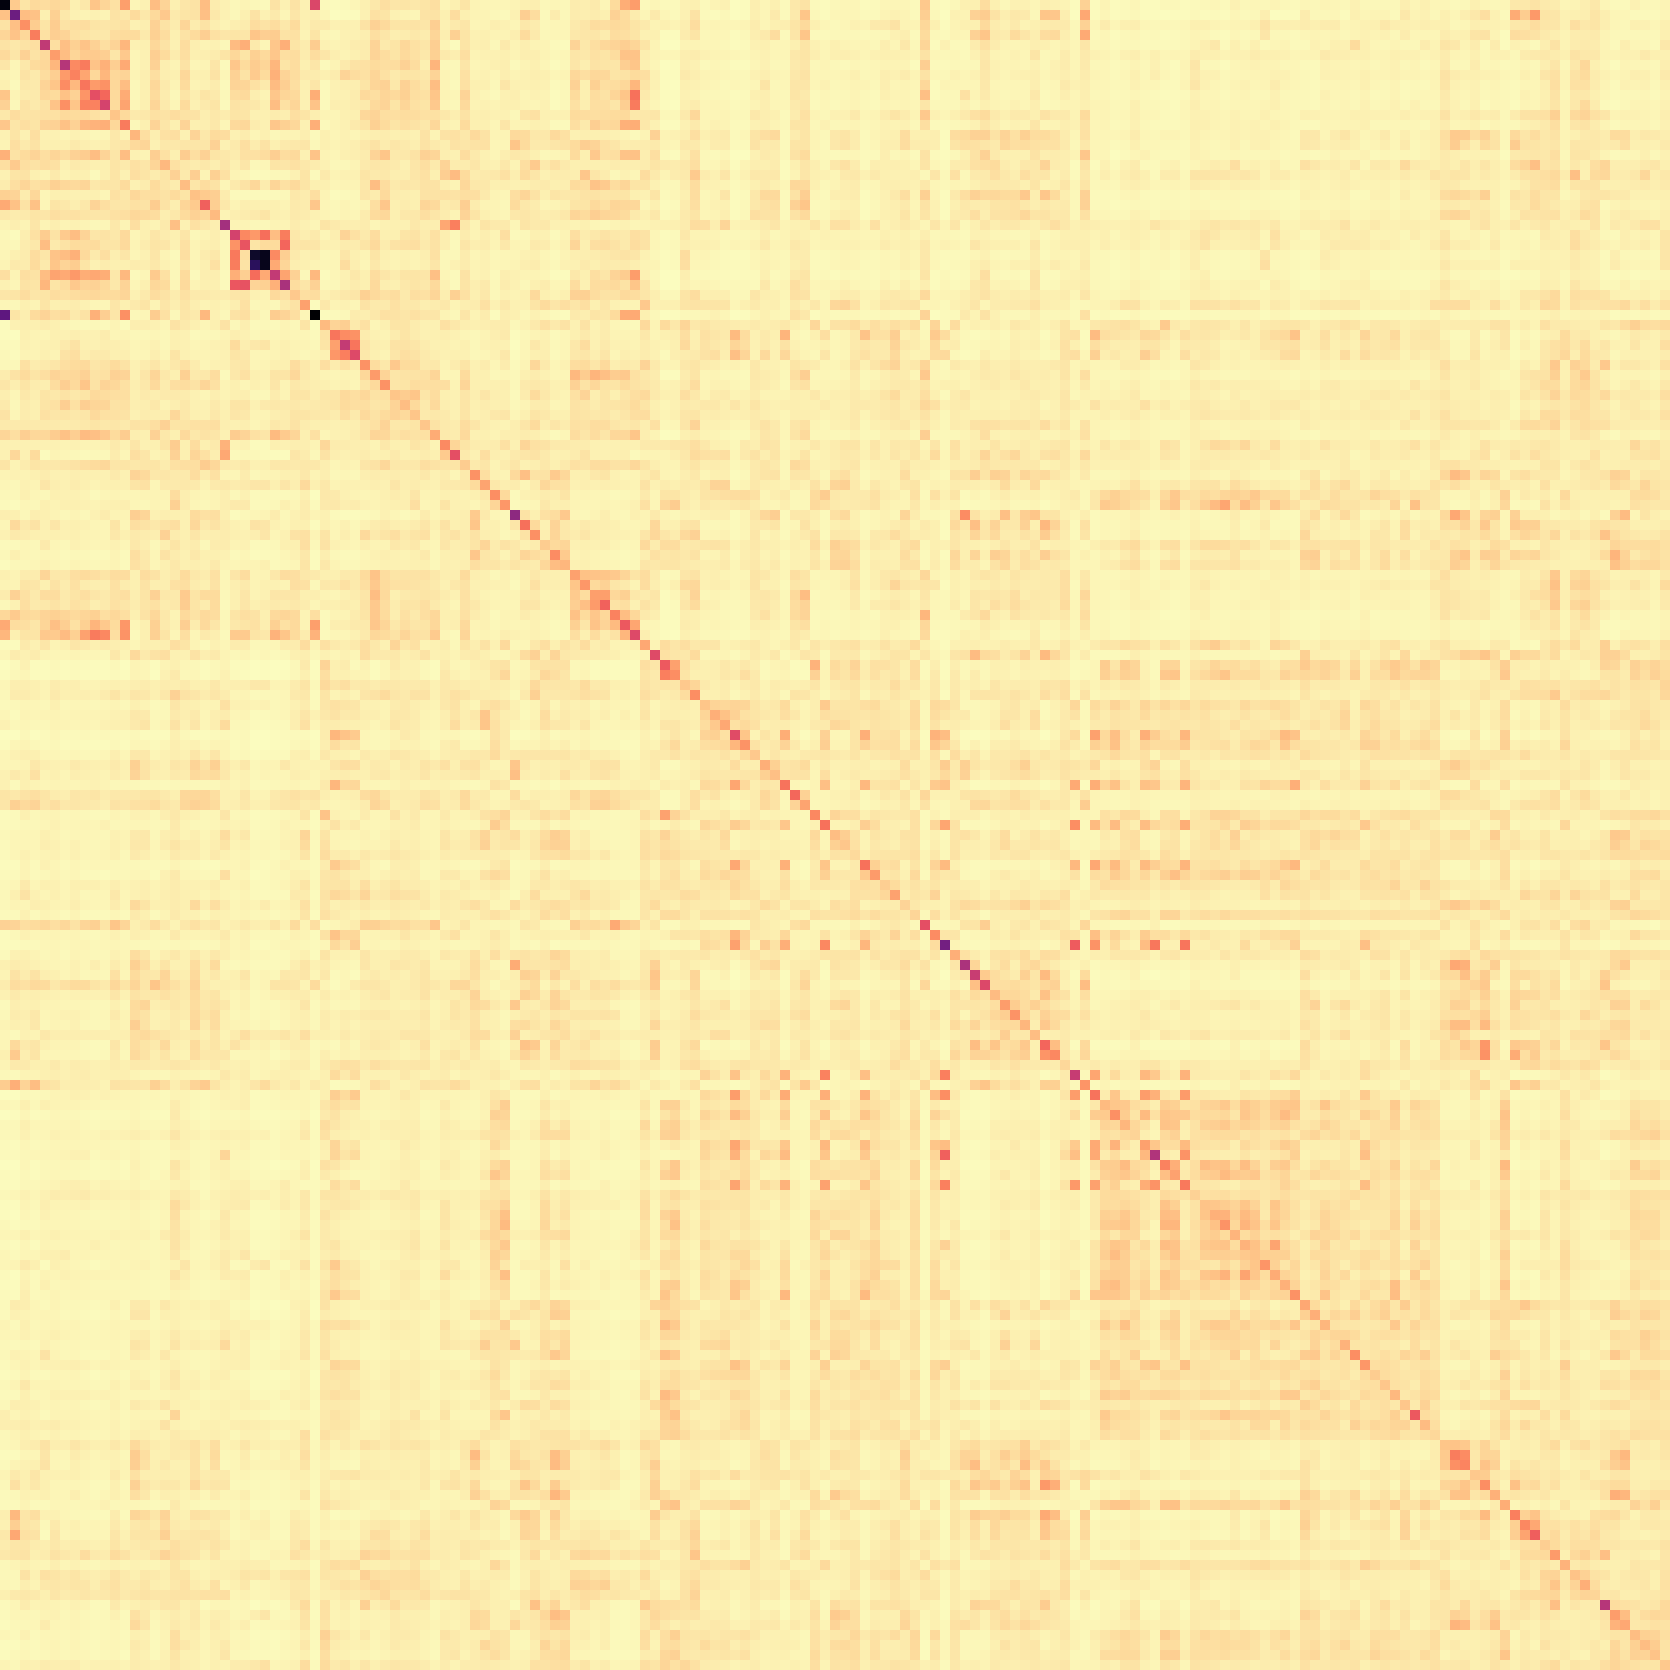

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = param_list[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("param_list:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(param_list)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(param_list), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

param_list:
  0: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[100]'
  1: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[75]'
  2: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[50]'
  3: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]'

model:
  params[-1/4]: 'classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]'
  fold[0/20]

model_id                      classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25], fold[0]
params                                 classifier[cls: rf, random_state: 0, criterion: gini, n_estimators: 1000], downsample_classes[25]
params_dict        {'classifier': {'cls': 'rf', 'random_state': 0, 'criterion': 'gini', 'n_estimators': 1000}, 'downsample_classes': 25}
classifier_type   

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
    )

[skip]